In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from __future__ import division, print_function, absolute_import

In [20]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns

# Using the Model to Make Predictions 

First, let's locate the latest model: It's called ```saved_model.pb```.

In [21]:
with open('temp_dir.txt') as file:
    temp_dir = file.read()
import os
model_dir = os.path.join(temp_dir, "models/export/exporter")
versions = !ls $model_dir
print( "Versions: %s" % versions)
latest_version = max(versions)
latest_model = os.path.join(model_dir, str(latest_version))
!echo $latest_model
!ls $latest_model

Versions: ['1558881490', '1558881491']
C:\Users\wgi\AppData\Local\Temp\tmp_61u0qur\models/export/exporter\1558881491
saved_model.pb
variables


Create an estimator from that model:

In [22]:
estimator = tf.contrib.predictor.from_saved_model(latest_model)

INFO:tensorflow:Restoring parameters from C:\Users\wgi\AppData\Local\Temp\tmp_61u0qur\models/export/exporter\1558881491\variables\variables


Use it to predict the humidity for a single record:

In [6]:
sample = {
    'beta1': [[1.234],[1.234]],
    'beta2': [[1.234],[1.234]],
    'weekday': [[5], [6]],
    'hour': [[16], [17]]
}

In [7]:
estimator(sample)

{'output': array([[28.604445],
        [20.201504]], dtype=float32)}

### Verifying prediction quality against the test set

In [8]:
!ls $temp_dir

eval.tfr-00000-of-00001
metadata
models
signature_eval.csv
signature_test.csv
signature_train.csv
tftransform_tmp
training.csv-00000-of-00001
training.tfr-00000-of-00001


In [9]:
test_data = pd.read_csv(os.path.join(temp_dir, "signature_test.csv"))
test_data.head()

,beta1,beta2,hour,humidity,weekday
0,0.015548,3.381195,23,17.082348,0
1,-0.601714,-4.417270,0,20.766023,1
2,-3.529717,-2.774476,10,12.924191,6
3,4.748839,-1.575845,8,29.878196,5
4,-0.858826,3.025703,4,15.092952,1


In [10]:
test_dict = test_data.drop('humidity', axis=1).to_dict(orient='list')
test_dict = { key: np.reshape(item, [-1,1]) for key, item in test_dict.items()}

In [11]:
predicted = estimator(test_dict)
len(predicted['output'])

20000

In [12]:
test_data['predicted'] = predicted['output'].reshape(-1)

In [13]:
test_data.head()

,beta1,beta2,hour,humidity,weekday,predicted
0,0.015548,3.381195,23,17.082348,0,17.297281
1,-0.601714,-4.417270,0,20.766023,1,19.565678
2,-3.529717,-2.774476,10,12.924191,6,12.994267
3,4.748839,-1.575845,8,29.878196,5,28.850666
4,-0.858826,3.025703,4,15.092952,1,15.263662


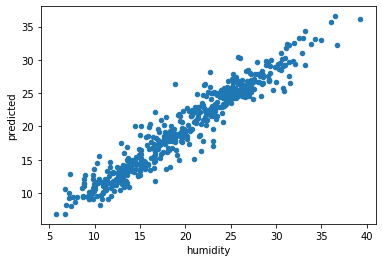

In [14]:
%matplotlib inline
test_data[:500].plot.scatter(x='humidity', y='predicted');

Our prediction strongly correlates with the measured humidity.

In [15]:
test_data['diff'] = test_data['humidity'] - test_data['predicted']

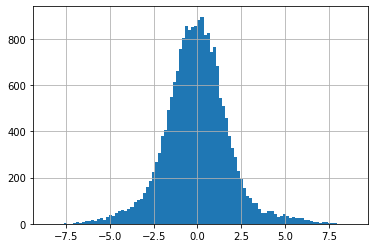

In [16]:
test_data['diff'].hist(bins=100);

And also, the error distribution is truly convincing. The remaining error is almost perfectly Gaussian.

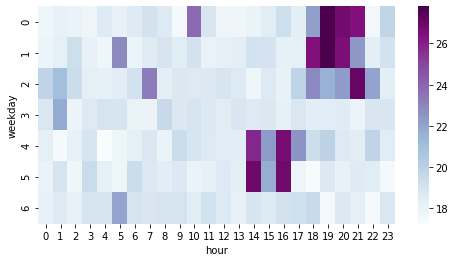

In [17]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,4))
sns.heatmap(test_data.pivot_table(
    index='weekday', columns='hour', 
    values='predicted', aggfunc='mean'), cmap='BuPu');

The heatmap of predictions, averaged over $\beta_1$ and $\beta_2$ clearly shows that the model has figured out the anomaly that can be observed Mon-Wed between 18:00 and 21:00 and Fri-Sat between 14:00 and 16:00 hours.